# 1. Conditional Variational Autoencoder
A Conditional Variational Autoencoder (CVAE) is an extension of the Variational Autoencoder (VAE) that incorporates conditional information into the model. This additional information allows the CVAE to generate data conditioned on some input variables, enabling more control over the data generation process. 

## 1.1. Variational Autoencoder (VAE) Recap
A VAE is a generative model that learns to encode data into a latent space and then decode this latent representation back into the original data space. It consists of two main components:
- **Encoder**: Maps input data to a latent space, producing parameters for a probability distribution (typically mean and variance of a Gaussian).
- **Decoder**: Generates data from samples drawn from the latent space.

The VAE optimizes a loss function that includes:
1. **Reconstruction Loss**: Measures how well the decoded data matches the original input.
2. **KL Divergence**: Ensures the latent space distribution approximates a prior distribution (usually a standard normal distribution).

## 1.2. Conditional VAE (CVAE)
The CVAE extends the VAE by incorporating additional conditional information $ y $ (e.g., class labels, attributes) into both the encoder and decoder. This conditioning allows the model to generate data that is not only realistic but also adheres to specific conditions.

### 1.2.1. Architecture
- **Encoder**: Takes both the input data $ x $ and the conditional information $ y $ to produce the latent variables.
- **Decoder**: Receives the latent variables and the conditional information $ y $ to generate the output data.

### 1.2.2. Objective Function
The CVAE optimizes a similar loss function as the VAE, with the addition of conditioning:
1. **Conditional Reconstruction Loss**: Ensures the decoder reconstructs the input data $ x $ conditioned on $ y $.
2. **Conditional KL Divergence**: Ensures the latent space distribution conditioned on $ y $ approximates the prior distribution.

### 1.2.3. Formulation
Given input $ x $ and conditional information $ y $, the loss function for a CVAE is:
$$ \mathcal{L}(\theta, \phi; x, y) = \mathbb{E}_{q_\phi(z|x, y)} [\log p_\theta(x|z, y)] - D_{KL}(q_\phi(z|x, y) || p(z|y)) $$

- $ q_\phi(z|x, y) $: Encoder's approximate posterior distribution of latent variables.
- $ p_\theta(x|z, y) $: Decoder's likelihood of reconstructing $ x $ from $ z $ and $ y $.
- $ p(z|y) $: Prior distribution of the latent variables conditioned on $ y $.

### 1.2.4. Applications
CVAE has various applications, including:
- **Conditional Image Generation**: Generating images based on specific attributes or class labels (e.g., generating faces with specific features).
- **Data Imputation**: Filling in missing data points conditioned on observed values.
- **Sequence-to-Sequence Models**: In natural language processing, generating text conditioned on certain prompts or contexts.

### 1.2.5. Advantages
- **Controlled Generation**: Ability to generate data that satisfies specific conditions.
- **Enhanced Flexibility**: More versatile compared to standard VAEs due to the incorporation of additional information.

The Conditional Variational Autoencoder is a powerful generative model that leverages conditional information to enhance control and specificity in data generation tasks, making it a valuable tool in various machine learning and artificial intelligence applications. In this notebook we shall present a simple conditional VAE, trained on MNIST. 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from keras.datasets import mnist
from tensorflow.keras import losses
import numpy as np
import matplotlib.pyplot as plt

2024-05-21 09:49:11.570850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 09:49:11.570944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 09:49:11.721635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The conditional autoencoder will allow to generate specific digits in the MNIST range 0-9. The condition is passed as input to encoder and decoder in categorical format.

In [2]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train),28,28,1))
x_test = x_test.reshape((len(x_test),28,28,1))
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 2. Model

Implementing `Sampling` function as its usage disscussed in [previous project](https://www.kaggle.com/code/alishohadaee/dl-variational-autoencoder).

In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Main dimensions for the model (a simple stack of dense layers).

In [4]:
input_dim = (28, 28, 1)
latent_dim = 16

## 2.1. Encoder
First we define Encoder model of Conditional VAE. 

#### Code Explanation 
- The Following code defines an encoder model for a Conditional Variational Autoencoder (CVAE) using TensorFlow and Keras. The model takes two inputs: the input data $ x $ and the conditional information $ c $. 

##### Input Layers
- `x`: The primary input to the model, with a shape specified by `input_dim`.
- `c`: The conditional input with a fixed shape of 10.


##### Conditioning Input
- `cv`: The conditional input is reshaped by adding two dimensions, making it compatible with the spatial dimensions of the input image.
- `layers.UpSampling2D((28, 28), interpolation='nearest')`: Upsamples `c` to match the spatial dimensions of the input image (`28x28`), replicating the conditional information across the entire image.


##### Concatenation
- Concatenates the upsampled conditional information with the primary input data along the channel axis.


##### Convolutional Layers
- Series of convolutional layers interleaved with batch normalization and activation functions.
- `Conv2D`: Convolutional layers with varying filters (16, 32, 64), kernel sizes (3x3), strides, and activations (`swish`).
- `BatchNormalization`: Normalizes the activations of the previous layer at each batch, improving training stability and speed.
- `Activation('swish')`: Applies the Swish activation function.


##### Flatten and Dense Layers
- `Flatten()`: Flattens the multi-dimensional output from the convolutional layers into a single vector.
- `Dense(64, activation='swish')`: Fully connected layer with 64 units and Swish activation.


##### Latent Space
- `z_mean`: Dense layer representing the mean of the latent variable distribution.
- `z_log_var`: Dense layer representing the logarithm of the variance of the latent variable distribution.


##### Encoder Model
- Defines the encoder model with inputs `[x, c]` and outputs `[z_mean, z_log_var]`.


This encoder architecture is designed to map the input data $ x $ and the conditional information $ c $ to a latent space characterized by the mean (`z_mean`) and logarithm of the variance (`z_log_var`). The conditional information is incorporated into the model early in the architecture by concatenating it with the primary input after upsampling to match the input dimensions. This setup allows the decoder to generate outputs conditioned on specific attributes or labels provided by $ c $.

In [5]:
# Input Layers
x = layers.Input(shape=input_dim)
c = layers.Input(shape=(10,))

# Conditioning Input
cv = layers.Lambda(lambda c: tf.expand_dims(c, axis=1))(c)
cv = layers.Lambda(lambda c: tf.expand_dims(c, axis=1))(cv)
cv = layers.UpSampling2D((28, 28), interpolation='nearest')(cv)

# Concatenate and Convolutional Layer 
y = layers.concatenate([x, cv])
y = layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('swish')(y)
y = layers.Conv2D(16, (3, 3), activation='swish', padding='same')(y)
y = layers.Conv2D(32, (3, 3), strides=(2, 2), activation='swish', padding='same')(y)
y = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(y)
y = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='swish', padding='same')(y)
y = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(y)
y = layers.Flatten()(y)
y = layers.Dense(64, activation='swish')(y)

# Latent space
z_mean = layers.Dense(latent_dim)(y)
z_log_var = layers.Dense(latent_dim)(y)

# Encoder model
encoder = Model([x, c], [z_mean, z_log_var])

In [6]:
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 10)     │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 1, 10)  │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 28, 28,    │          0 │ lambda_1[0][0]    │
│ (UpSampling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 11)               │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │      1,600 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 32)  │      4,640 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 32)  │      9,248 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     65,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,976 (550.69 KB)

 Trainable params: 140,944 (550.56 KB)

 Non-trainable params: 32 (128.00 B)

## 2.2. Decoder
Let's define the decoder model for the Conditional VAE. 

#### Code Explanation
- Following code takes two inputs: the latent representation $ x $ and the conditional information $ c $. 


##### Input Layers
- `x`: The latent representation input to the decoder, with a shape specified by `latent_dim`.
- `c`: The conditional input with a fixed shape of 10.


##### Concatenation and Dense Layers
- `layers.concatenate([x, c])`: Concatenates the latent representation and the conditional information.
- `layers.Dense(128, activation='swish')(y)`: Fully connected layer with 128 units and Swish activation. This helps in processing the concatenated input and learning a better representation.
- The second `layers.concatenate([x, c])` seems redundant here. If this is intentional, it would imply concatenating the original inputs again, but typically, it should follow further processing if needed.


##### Fully Connected and Reshape Layers
- `layers.Dense(1024, activation='swish')(y)`: Another fully connected layer with 1024 units and Swish activation, further processing the combined latent and conditional information.
- `layers.Reshape((4, 4, 64))(y)`: Reshapes the output into a 4x4x64 tensor, preparing it for the convolutional layers that follow.


##### Convolutional and Transpose Convolutional Layers
- Series of `Conv2D` and `Conv2DTranspose` layers interleaved to perform convolutional operations and upsampling.
  - `Conv2D`: Standard convolutional layers with Swish activation.
  - `Conv2DTranspose`: Transpose convolutional layers (also known as deconvolutional layers) to upsample the feature maps.
  - `BatchNormalization`: Normalizes the activations to stabilize and speed up training.
  - `Activation('swish')`: Applies the Swish activation function.


##### Output Layer
- `layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)`: Final convolutional layer with a single filter, using a sigmoid activation function to generate the output image. The sigmoid activation ensures that the output values are between 0 and 1, which is typical for image data.


##### Decoder Model
- Defines the decoder model with inputs `[x, c]` and output `y`.


This decoder architecture is designed to take a latent representation and conditional information as inputs and generate an output image that adheres to the specified conditions. The process involves:
- Concatenating the latent and conditional inputs.
- Passing through dense layers to process the concatenated input.
- Reshaping the processed output to prepare for convolutional layers.
- Using a series of convolutional and transpose convolutional layers to upsample and generate the final image.
- Applying batch normalization and activation functions to improve training stability and performance.
- Producing the final image with a single channel and pixel values in the range [0, 1] using the sigmoid activation function.

This decoder, when paired with the corresponding encoder, forms a Conditional Variational Autoencoder capable of generating images conditioned on specific attributes or labels provided in the conditional input.

In [7]:
# Input layers 
x_d = layers.Input(shape=(latent_dim,))
c_d = layers.Input(shape=(10, ))

# Concatenation and Dense Layer
y = layers.concatenate([x_d, c_d])
y = layers.Dense(128, activation='swish')(y)
y = layers.concatenate([x_d, c_d])

# Reshaping
y = layers.Dense(1024, activation='swish')(y)
y = layers.Reshape((4, 4, 64))(y)

# Convolutional Layer
y = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(y)
y = layers.Conv2DTranspose(32, (3, 3),strides=(2, 2), activation='swish', padding='same')(y)
y = layers.Conv2D(32, (3, 3),activation='swish', padding='same')(y)
y = layers.Conv2DTranspose(16, (3, 3),strides=(2, 2), activation='swish', padding='same')(y)
y = layers.Conv2D(16, (3, 3),activation='swish', padding='valid')(y)
y = layers.Conv2DTranspose(16, (3, 3),strides=(2, 2), activation='swish', padding='same')(y)
y = layers.Conv2D(16, (3, 3), padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('swish')(y)

# Output Layer
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)

# Decoder Model
decoder = Model([x_d, c_d], output)

In [8]:
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 26)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │     27,648 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 32)  │     18,464 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │      4,624 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │      2,320 │ conv2d_transpose… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 28, 28,    │      2,320 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │      2,320 │ conv2d_transpose… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28, 1) │        145 │ activation_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,081 (406.57 KB)

 Trainable params: 104,049 (406.44 KB)

 Non-trainable params: 32 (128.00 B)

## 2.3. CVAE Model
Creating CVAE Final Model

In [9]:
class CVAE(Model):
    def __init__(self, encoder, decoder, gamma=1.0, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.gamma = gamma

    def train_step(self, data):
        x, c = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder([x, c])
            z = sampling([z_mean, z_log_var])
            x_hat = self.decoder([z, c])
            loss = vae_loss(x, x_hat, z_mean, z_log_var, self.gamma)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        x, c = data

        z_mean, z_log_var = self.encoder([x, c])
        z = sampling([z_mean, z_log_var])
        x_hat = self.decoder([z, c])
        loss = vae_loss(x, x_hat, z_mean, z_log_var, self.gamma)
        return {"loss": loss}
    
    def call(self, inputs):
        x, c = inputs
        z_mean, z_log_var = self.encoder([x, c])
        z = sampling([z_mean, z_log_var])
        return self.decoder([z, c])

Below is the VAE Loss Function:

In [10]:
def vae_loss(x, x_hat, z_mean, z_log_var, gamma):
    rec_loss = K.mean(losses.mean_squared_error(x, x_hat), axis=(1, 2))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(rec_loss + gamma * kl_loss)

Some hyperparameters. Gamma is used to balance loglikelihood and KL-divergence in the loss function

In [11]:
gamma = .0001

In [12]:
cvae = CVAE(encoder, decoder, gamma=gamma)

cvae.summary()

Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │       140,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ ?                      │       104,081 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,057 (957.25 KB)

 Trainable params: 244,993 (957.00 KB)

 Non-trainable params: 64 (256.00 B)

In [13]:
batch_size = 128
epochs = 60

We are ready to compile. We specify the loss function with Compile method. 

In [14]:
optimizer = optimizers.Adam(learning_rate=.0005)

In [15]:
cvae.compile(optimizer=optimizer, loss=vae_loss)

Training 

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

cvae.fit(train_dataset, epochs=epochs)

Epoch 1/60
 15/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2264

I0000 00:00:1716284979.561928      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716284979.583610      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716284979.590362      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.0781
Epoch 2/60
 11/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0498

W0000 00:00:1716284988.938528      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0352
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0227
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0186
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0167
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0153
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0143
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0136
Epoch 9/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0131
Epoch 10/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0127
Epoch 11/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0123
Epoch 12/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0121
Epoch 13/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0118
Epoch 14/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0116
Epoch 15/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0114
Epoch 16/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0113

Let us decode the full test set.

In [17]:
decoded_imgs = cvae.predict((x_test, y_test))

 71/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716285187.568099      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


The following function is to test the quality of reconstructions (not particularly good, since compression is strong).

In [18]:
def plot(n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

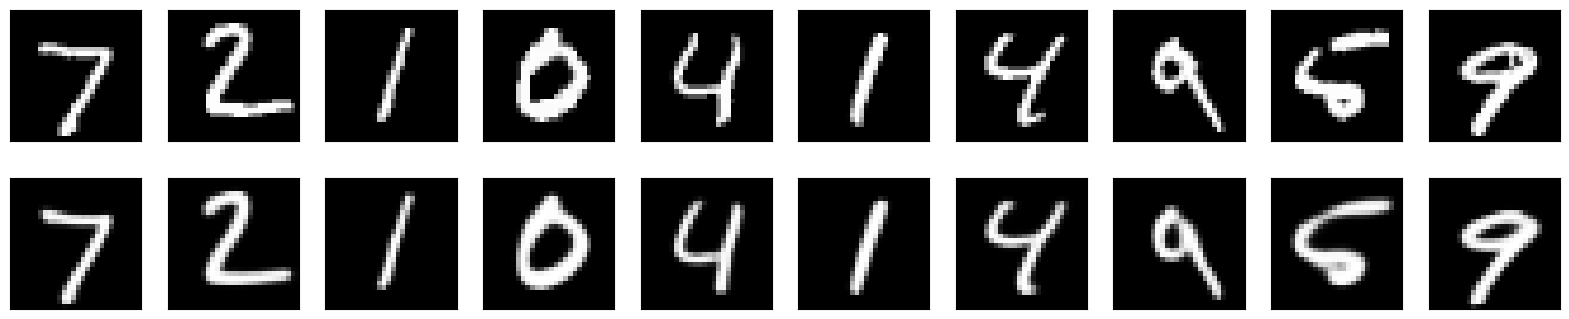

In [19]:
plot()

Finally, we build a digit generator that can sample from the learned distribution

In [20]:
generator = decoder

And we can generate our samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


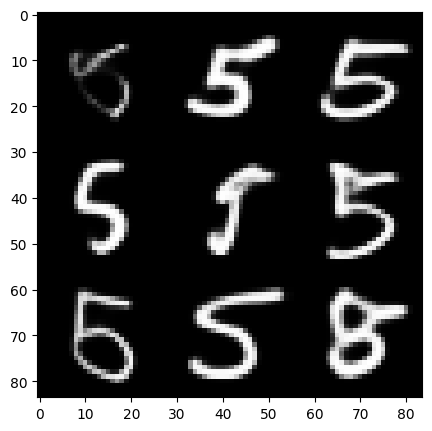

In [21]:
import time
# display a 2D manifold of the digits
n = 3  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

while True:
    # Uncomment next line to try more example
#     label = input("input digit to generate: \n")
    # and comment this one after it
    label = 5
    label = int(label)
    if label < 0 or label > 9:
        print(label)
        break

    label = np.expand_dims(utils.to_categorical(label, 10),axis=0)
    for i in range(0,n):
        for j in range (0,n):
            z_sample = np.expand_dims(np.random.normal(size=latent_dim),axis=0)
            x_decoded = generator.predict([z_sample,label])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            
    plt.figure(figsize=(5, 5))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    time.sleep(1)
    
    # Comment next line for more input
    break
